# load data

In [1]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# from jupyterthemes import jtplot
# jtplot.style(theme='gruvboxd')
# jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
# jtplot.style(ticks=True, grid=False, figsize=(6.5, 5))

import pandas as pd
import numpy as np

In [2]:
# # train_data
# # 882808:117192
# train_data = pd.read_csv("./train.csv",parse_dates=['auditing_date','due_date','repay_date']) #201801-20181231

# # test_data
# test_data = pd.read_csv("./test.csv",parse_dates=['auditing_date','due_date']) #20190201-20190331

# # listing_info
# listing_info = pd.read_csv("./listing_info.csv")

# # user_info
user_info = pd.read_csv("./user_info.csv",parse_dates = ['reg_mon','insertdate']) #20171231-20190330

# # user_taglist
# user_taglist = pd.read_csv("./user_taglist.csv",parse_dates = ['insertdate']) #20171231-20190330

# # user_behavior
# user_behavior = pd.read_csv("./user_behavior.csv",parse_dates=['behavior_time']) # 20170705-20190330

# # user_repay
# user_repay = pd.read_csv("./user_repay.csv",parse_dates=['auditing_date','due_date','repay_date']) # 20170705-20200330

In [3]:
# user_repay[(user_repay['auditing_date']<="20190201")&(user_repay['auditing_date']>="20190101")&(user_repay['order_id']==1)]
# 62133
# 57222:4911

# user_repay[(user_repay['auditing_date']<="20181231")&(user_repay['auditing_date']>="20170705")&(user_repay['order_id']==1)] 
# 2665908
# 2493623:173985

# user_repay[(user_repay['auditing_date']<="20181231")&(user_repay['auditing_date']>="20180101")&(user_repay['order_id']==1)] 
# 1960867
# 1854069:113358

# user_repay[(user_repay['auditing_date']<="20181231")&(user_repay['auditing_date']>="20180101")&(user_repay['order_id']==1)]\
# .drop('order_id',axis=1).set_index(['user_id','listing_id']) \.loc[train_data.set_index(['user_id','listing_id']).index]

# user_repay:20190101-20190131 样本外验证
# user_repay:20180101-20181231 暂留
# user_repay:20170705-20171231 距离较远直接舍弃

# concat train_set

## concat listing_info

In [26]:
train_set = pd.merge(train_data,listing_info,how='left',on=['user_id','listing_id'])
print(train_set.shape)
print("duplicated:\n",train_set.duplicated().value_counts())

(1000000, 14)
duplicated:
 False    1000000
dtype: int64


## concat user_info

In [27]:
train_set = pd.merge(train_set,user_info,how='left',on=['user_id'])
print(train_set.shape)
print("duplicated:\n",train_set.duplicated().value_counts())

(1034565, 26)
duplicated:
 False    1034565
dtype: int64


In [28]:
train_set = train_set[train_set['insertdate']<=train_set['auditing_date']] #用户信息获取时间必须在成交日之前
train_set.drop('insertdate',axis=1,inplace=True)
train_set.shape

(1000594, 25)

## concat user_taglist

In [29]:
train_set = pd.merge(train_set,user_taglist,how='left',on=['user_id'])
print(train_set.shape)
print("duplicated:\n",train_set.duplicated().value_counts())

(1183850, 37)
duplicated:
 False    1183850
dtype: int64


In [33]:
train_set = train_set[train_set['insertdate']<=train_set['auditing_date']] #用户标签信息获取时间必须在成交日之前
train_set.drop('insertdate',axis=1,inplace=True)
train_set.shape

F:\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(653304, 36)

In [34]:
train_set.to_csv("./train_set_nobehavior_norepay.csv",index=False)

## concat user_behavior

In [3]:
train_set = pd.read_csv("./train_set_nobehavior_norepay.csv",
                        parse_dates=['auditing_date','due_date','repay_date','reg_mon'])

In [4]:
train_set = pd.merge(train_set,user_behavior,how='left',on=['user_id'])
del user_behavior
print(train_set.shape)
print("duplicated:\n",train_set.duplicated().value_counts())

(19157034, 44)
duplicated:
 False    19155758
True         1276
dtype: int64


In [5]:
cond1 = (train_set['behavior_time']<=train_set['auditing_date']) # 用户行为需发生在成交之前
cond2 = ((train_set['auditing_date']-train_set['behavior_time']).dt.days<=90) # 把行为限定在成交前三个月内
train_set = train_set[cond1&cond2] 
train_set.shape

(7753422, 44)

In [6]:
train_set = train_set.drop_duplicates()
print(train_set.shape)

(7752905, 44)


In [7]:
train_set = train_set.drop(['behavior_time','same_behavior_count1d'],axis=1).drop_duplicates()
train_set.shape

(7540885, 42)

## data transform

### audit_reg_delta

In [8]:
train_set['audit_reg_delta'] = (train_set['auditing_date']-train_set['reg_mon']).dt.days #衡量用户新旧

### dummy

#### province

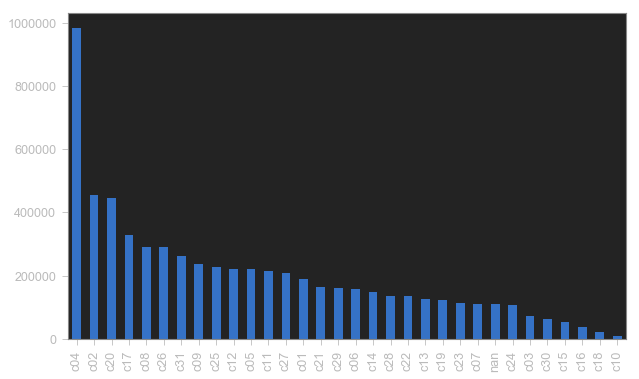

In [12]:
plt.figure(figsize=(10,6))
train_set['cell_province'].value_counts(dropna=False).plot(kind='bar')

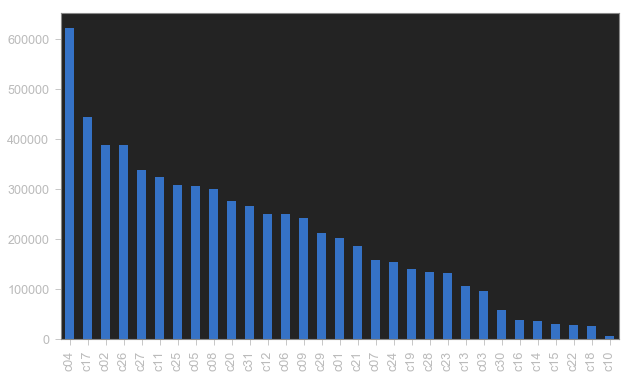

In [13]:
plt.figure(figsize=(10,6))
train_set['id_province'].value_counts(dropna=False).plot(kind='bar')

In [38]:
# c04
# c02 c20 
# c17 c08 c26 c31 c09 c25 c12 c05 c11 c27
# c01 c21 c29 c06 c14 c28 c22 c13 c19 c23 c07 c24
# c03  c30  c15  c16  c18  c10   
# nan

# train_set['cell_province'].value_counts(dropna=False)
cond_1 = (train_set['cell_province'] =='c04')

cond_2 = (train_set['cell_province'] =='c02')|(train_set['cell_province'] =='c20')

cond_3 = ((train_set['cell_province'] =='c17')|(train_set['cell_province'] =='c08')|
        (train_set['cell_province'] =='c26')|(train_set['cell_province'] =='c31')|
        (train_set['cell_province'] =='c09')|(train_set['cell_province'] =='c25')|
        (train_set['cell_province'] =='c12')|(train_set['cell_province'] =='c05')|
        (train_set['cell_province'] =='c11')|(train_set['cell_province'] =='c27'))

cond_4 = ((train_set['cell_province'] =='c01')|(train_set['cell_province'] =='c21')|
         (train_set['cell_province'] =='c29')|(train_set['cell_province'] =='c06')|
         (train_set['cell_province'] =='c14')|(train_set['cell_province'] =='c28')|
         (train_set['cell_province'] =='c22')|(train_set['cell_province'] =='c13')|
        (train_set['cell_province'] =='c19')|(train_set['cell_province'] =='c23')|
        (train_set['cell_province'] =='c07')|(train_set['cell_province'] =='c24'))

cond_5 = ((train_set['cell_province'] =='c03')|(train_set['cell_province'] =='c30')|
         (train_set['cell_province'] =='c15')|(train_set['cell_province'] =='c16')|
         (train_set['cell_province'] =='c18')|(train_set['cell_province'] =='c10'))

# cond_6 = (train_set['cell_province'].isnull())

train_set.loc[cond_1,'province_dummy'] = 1
train_set.loc[cond_2,'province_dummy'] = 2
train_set.loc[cond_3,'province_dummy'] = 3
train_set.loc[cond_4,'province_dummy'] = 4
train_set.loc[cond_5,'province_dummy'] = 5
# train_set.loc[cond_6,'cell_province'] = 6

In [42]:
train_set = pd.concat([train_set,
                       pd.get_dummies(train_set['province_dummy'],prefix ='province_dummy' ,dummy_na=True)],
                      axis=1)

#### age

In [46]:
train_set['age_dummy'] = pd.cut(train_set['age'],bins=[18,20,30,40,50,100],labels=[1,2,3,4,5])

In [47]:
train_set = pd.concat([train_set,
                       pd.get_dummies(train_set['age_dummy'],prefix ='age_dummy' ,dummy_na=True)],
                      axis=1)

### woe transform

In [54]:
train_set['y'] = (train_set['repay_amt'].isnull())*1

In [8]:
from woe import WOE

woe = WOE()

#### listing_cat

In [59]:
listing_cat_woe_map = woe.woe_single_x(train_set['listing_cat'].astype(str),train_set['y'])[0]
train_set['listing_cat'] = train_set['listing_cat'].astype(str).map(listing_cat_woe_map)

#### id_city

In [71]:
train_set['id_city'].value_counts(dropna=False).tail()#.to_dict()

c26033    121
c19058     88
c25339     46
c04339      9
c26178      3
Name: id_city, dtype: int64

In [74]:
few_city_map = {'c19058': 'c99999', 
                 'c25339':'c99999', 
                 'c04339':'c99999', 
                 'c26178':'c99999'}
train_set['id_city'] = train_set['id_city'].replace(few_city_map)

In [77]:
id_city_woe_map = woe.woe_single_x(train_set['id_city'].astype(str),train_set['y'])[0]
train_set['id_city'] = train_set['id_city'].astype(str).map(id_city_woe_map)

F:\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


#### id_province

In [63]:
id_province_woe_map = woe.woe_single_x(train_set['id_province'].astype(str),train_set['y'])[0]
train_set['id_province'] = train_set['id_province'].astype(str).map(id_province_woe_map)

#### cell_province

In [66]:
cell_province_woe_map = woe.woe_single_x(train_set['cell_province'].astype(str),train_set['y'])[0]
train_set['cell_province'] = train_set['cell_province'].astype(str).map(cell_province_woe_map)

In [18]:
# 2.5.3.5  age

# age_woe_map = woe.woe_single_x(train_set['age'].astype(str),train_set['y'])[0]
# train_set['age'] = train_set['age'].astype(str).map(age_woe_map)

### correlation

In [78]:
corr = train_set.corr()
corr.loc[:,:] = np.tril(corr,k=-1)
corr = corr.stack()
pd.DataFrame(corr[corr.abs()>=0.8],columns=["corr"])
# train_set.corr()

corr
repay_amt          due_amt              1.000000
principal          due_amt              0.848941
                   repay_amt            0.848027
pvi                term                 0.999854
gender_male        gender_female       -1.000000
same_province_True same_province_False -1.000000
tag_1              have_tags            1.000000
behavior_type_3.0  behavior_type_1.0   -0.844355
audit_reg_delta    user_id             -0.887537

In [25]:
# term gender_female same_province_False have_tags 
# train_set.columns
# train_set['age']

In [26]:
train_set = train_set.drop(['term','gender_female','same_province_False','have_tags',
                           'province_dummy','age_dummy'],axis=1)

### missing rate

In [27]:
train_set.apply(lambda x:x.isnull().sum()/len(x))

user_id               0.000000
listing_id            0.000000
auditing_date         0.000000
due_date              0.000000
due_amt               0.000000
repay_date            0.101894
repay_amt             0.101894
repay_date_delta      0.101894
auditing_days         0.000000
listing_cat           0.000000
rate                  0.000000
principal             0.000000
pvi                   0.000000
reg_mon               0.000000
cell_province         0.017728
id_province           0.000000
id_city               0.008455
gender_male           0.000000
gender_nan            0.000000
same_province_True    0.000000
same_province_nan     0.000000
tag_num               0.000000
tag_1                 0.000000
tag_2                 0.000000
tag_3                 0.000000
tag_4                 0.000000
tag_5                 0.000000
tag_6                 0.000000
tag_7                 0.000000
tag_8                 0.000000
tag_9                 0.000000
behavior_hour         0.000000
behavior

In [28]:
train_set.to_csv("./train_set.csv",index=False)